In [1]:
# from tensorboard.backend.event_processing import event_accumulator
# ea = event_accumulator.EventAccumulator('../runs/Sep12_15-52-32_baldeeb-desktop/events.out.tfevents.1631476352.baldeeb-desktop.149179.0')
# # ea = event_accumulator.EventAccumulator('../runs/Sep11_23-26-10_baldeeb-desktop/events.out.tfevents.1631417170.baldeeb-desktop.74534.0')
# ea.Reload()
# ea.Tags()

In [2]:

# descriptors = ea.Images('descriptor')
# images = ea.Images('image')

# images[-1].encoded_image_string

In [2]:
%cd /home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor


In [3]:
#temp config 
class cfg():
    dataset = 'unreal_parts'
    data_dir = '../simple_data'
    image_type = 'RGB'
    obj_class = 'mug'
    n_pair = 0
    n_nonpair_singleobj = 0 
    n_nonpair_bg = 0
    batch_size = 1
    workers = 1

    device = 'cuda:0'
    # device = 'cpu'

In [30]:
import torch 
from torchvision.models.segmentation import deeplabv3_resnet50

## Load model
file = '/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor/temp/results_old/first_successful_run/model_checkpoints/13_09_2021__11_29_03_19_final'
device = torch.device('cuda:0')
state_dict = torch.load(file, map_location=device)
backbone = deeplabv3_resnet50(num_classes=3).to(device)
backbone.load_state_dict(state_dict['model_state_dict'])

## Load data
from dataset import make_data_loader
dataloader = make_data_loader(split='train', args=cfg())

## Run model
descriptors, images = None, None
for im, batch in dataloader:
    images = im.to(device)
    descriptors = backbone(images)['out']
    break


augmenting  image
augmenting  image


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


augmenting  image
augmenting  image


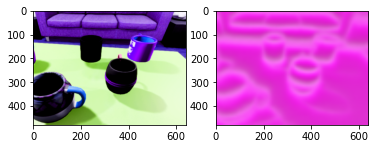

In [31]:
## De-Normalize
data_mean, data_std = [0.5183, 0.5747, 0.7210], [0.3218, 0.3045, 0.2688]  # Unreal Progress Mugs
im = images[0].clone().detach().cpu()
im = im * torch.tensor(data_std).reshape(-1, 1, 1) + torch.tensor(data_mean).reshape(-1, 1, 1)
d = descriptors[0].clone().detach().sigmoid().cpu()

# print(descriptors.min(), descriptors.max(), descriptors.mean(), descriptors.std())

## Visualize
import matplotlib.pyplot as plt
def visualize(image, descriptor):
    fig = plt.figure(); gs = fig.add_gridspec(1, 2); axs = gs.subplots()
    image = image.permute(1,2,0).float()
    descriptor = descriptor.permute(1,2,0).float()
    axs[0].imshow(image)
    axs[1].imshow(descriptor) 
    plt.show()

visualize(im, d)